In [1]:
%matplotlib inline

import random
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
import math
import statistics as st
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from tqdm.notebook import tqdm as tqdm
from scipy.stats import gamma

In [2]:
#### Data Import
datum = pd.read_csv('Data/Colonic Data/Colonic filling (NW Read et al., 1986).csv')
datum["Time"] = datum["Time"]*60
print(datum)

          Time   Filling
0   172.459016  0.003367
1   203.934426  0.100665
2   245.027322  0.202411
3   272.131148  0.302642
4   305.355191  0.407309
5   328.961749  0.509002
6   359.562842  0.610715
7   419.016393  0.711045
8   472.349727  0.811356
9   504.699454  0.914548
10  537.923497  1.014797


In [3]:
model = """
data {
    int N;
    real<lower=0> t[N];
    real Retention[N];
}

parameters {
    real<lower=0> alpha; 
    real logbeta;    
    real<lower=0> sigma;    
}

model {
    sigma ~ cauchy(0, 0.01);
    for(n in 1:N) {
        Retention[n] ~ normal(gamma_cdf(t[n], alpha, 10^logbeta), sigma);
    }
}

generated quantities {
    real<lower=0> beta;
    beta = 10^logbeta;
}

"""
sm_Colonic_filling = pystan.StanModel(model_code=model)

with open('stan_model_Colonic_filling.pkl', 'wb') as g:

    pickle.dump(sm_Colonic_filling, g)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_59c64013f3490da52241d160771a0cbc NOW.


In [4]:
fit_nuts_Colonic_filling = sm_Colonic_filling.sampling(
    data=dict(t = datum["Time"], Retention = datum["Filling"], N = len(datum["Time"])), 
    iter=5000, chains=4, thin=1, warmup=2500, seed=19941023, control=dict(adapt_delta=0.8, max_treedepth=10)
    ) 

In [5]:
print(fit_nuts_Colonic_filling)
samples = fit_nuts_Colonic_filling.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_Colonic_filling.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_Colonic_filling.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_Colonic_filling.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_Colonic_filling.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)

Inference for Stan model: anon_model_59c64013f3490da52241d160771a0cbc.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     8.87    0.03    1.2   6.84    8.1   8.76   9.49  11.58   1365    1.0
logbeta  -1.59  1.5e-3   0.06  -1.71  -1.63  -1.59  -1.56  -1.47   1631    1.0
sigma     0.04  2.3e-4   0.01   0.03   0.03   0.04   0.05   0.07   2127    1.0
beta      0.03  9.8e-5 3.6e-3   0.02   0.02   0.03   0.03   0.03   1359    1.0
lp__     25.79    0.03   1.44  22.14  25.13  26.15  26.85  27.44   1763    1.0

Samples were drawn using NUTS at Thu Jul 29 11:04:14 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


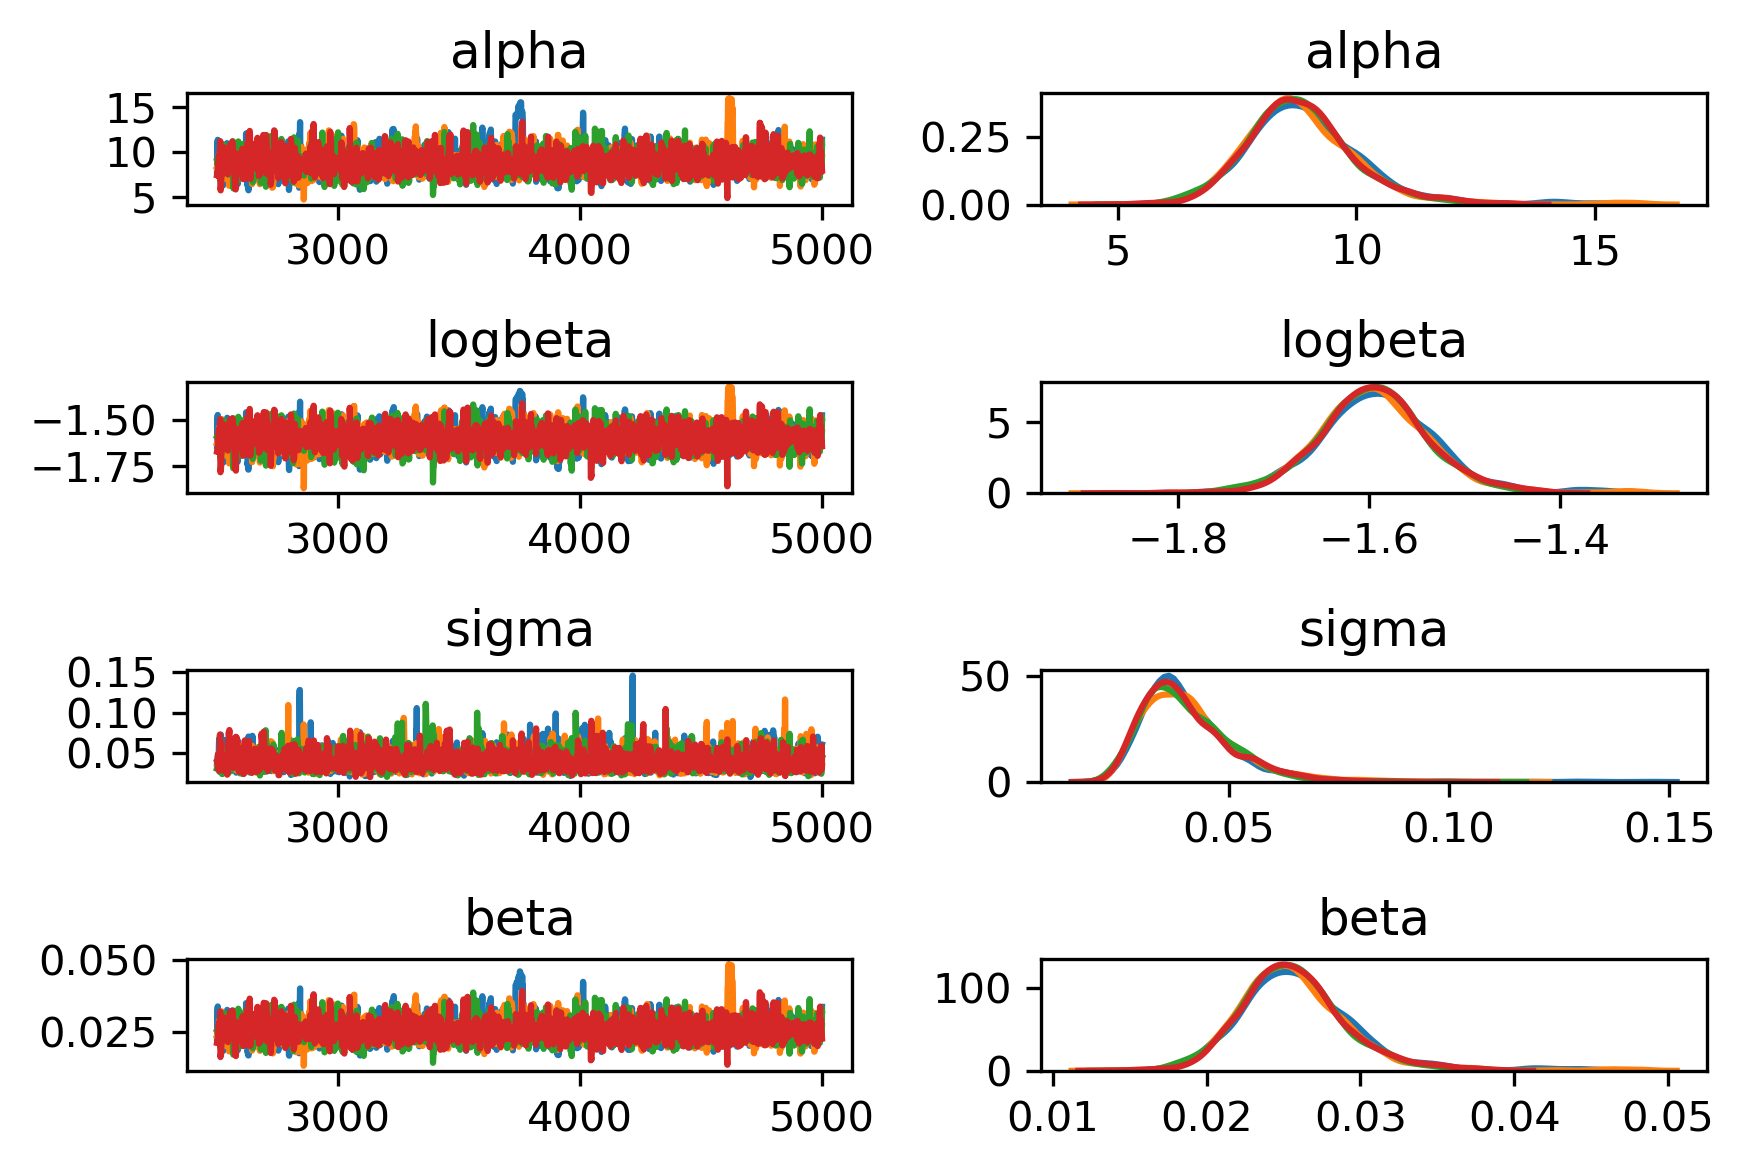

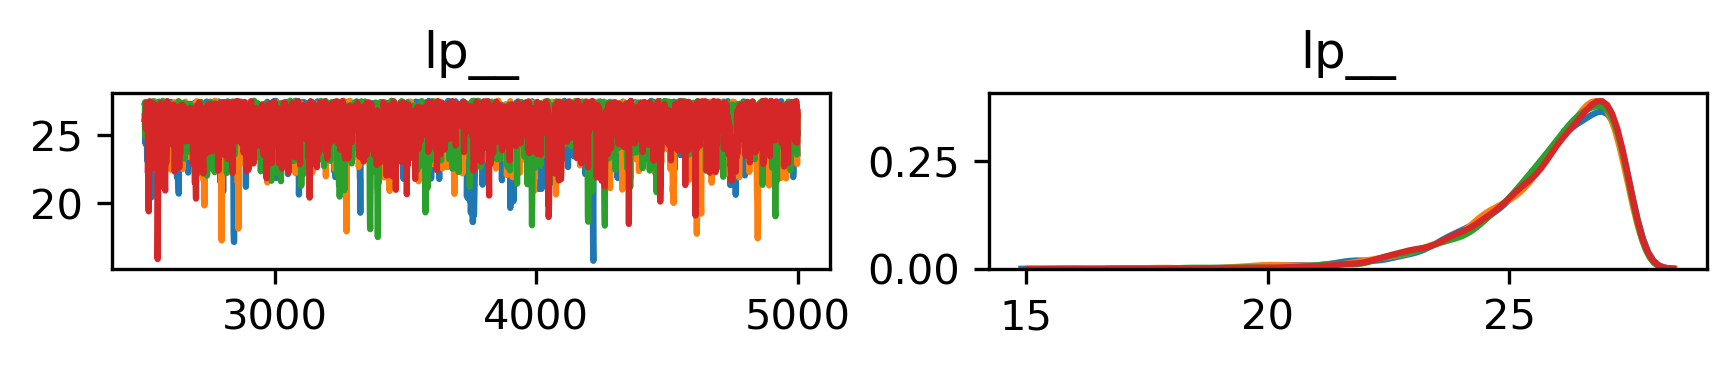

In [6]:
for pg in range(num_pages):
    plt.figure(dpi=300)
    pdf = PdfPages("Gastric Reduction/plot/traceplot/Bayesian Fitting Trace for Colonic filling"+str(pg)+".pdf")
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    pdf.savefig()
    pdf.close()
    plt.show()

In [7]:
with open('fit_nuts_Colonic_filling.pkl', 'wb') as g:

    pickle.dump(fit_nuts_Colonic_filling, g)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
samples_Colonic_filling = fit_nuts_Colonic_filling.extract(permuted=True)

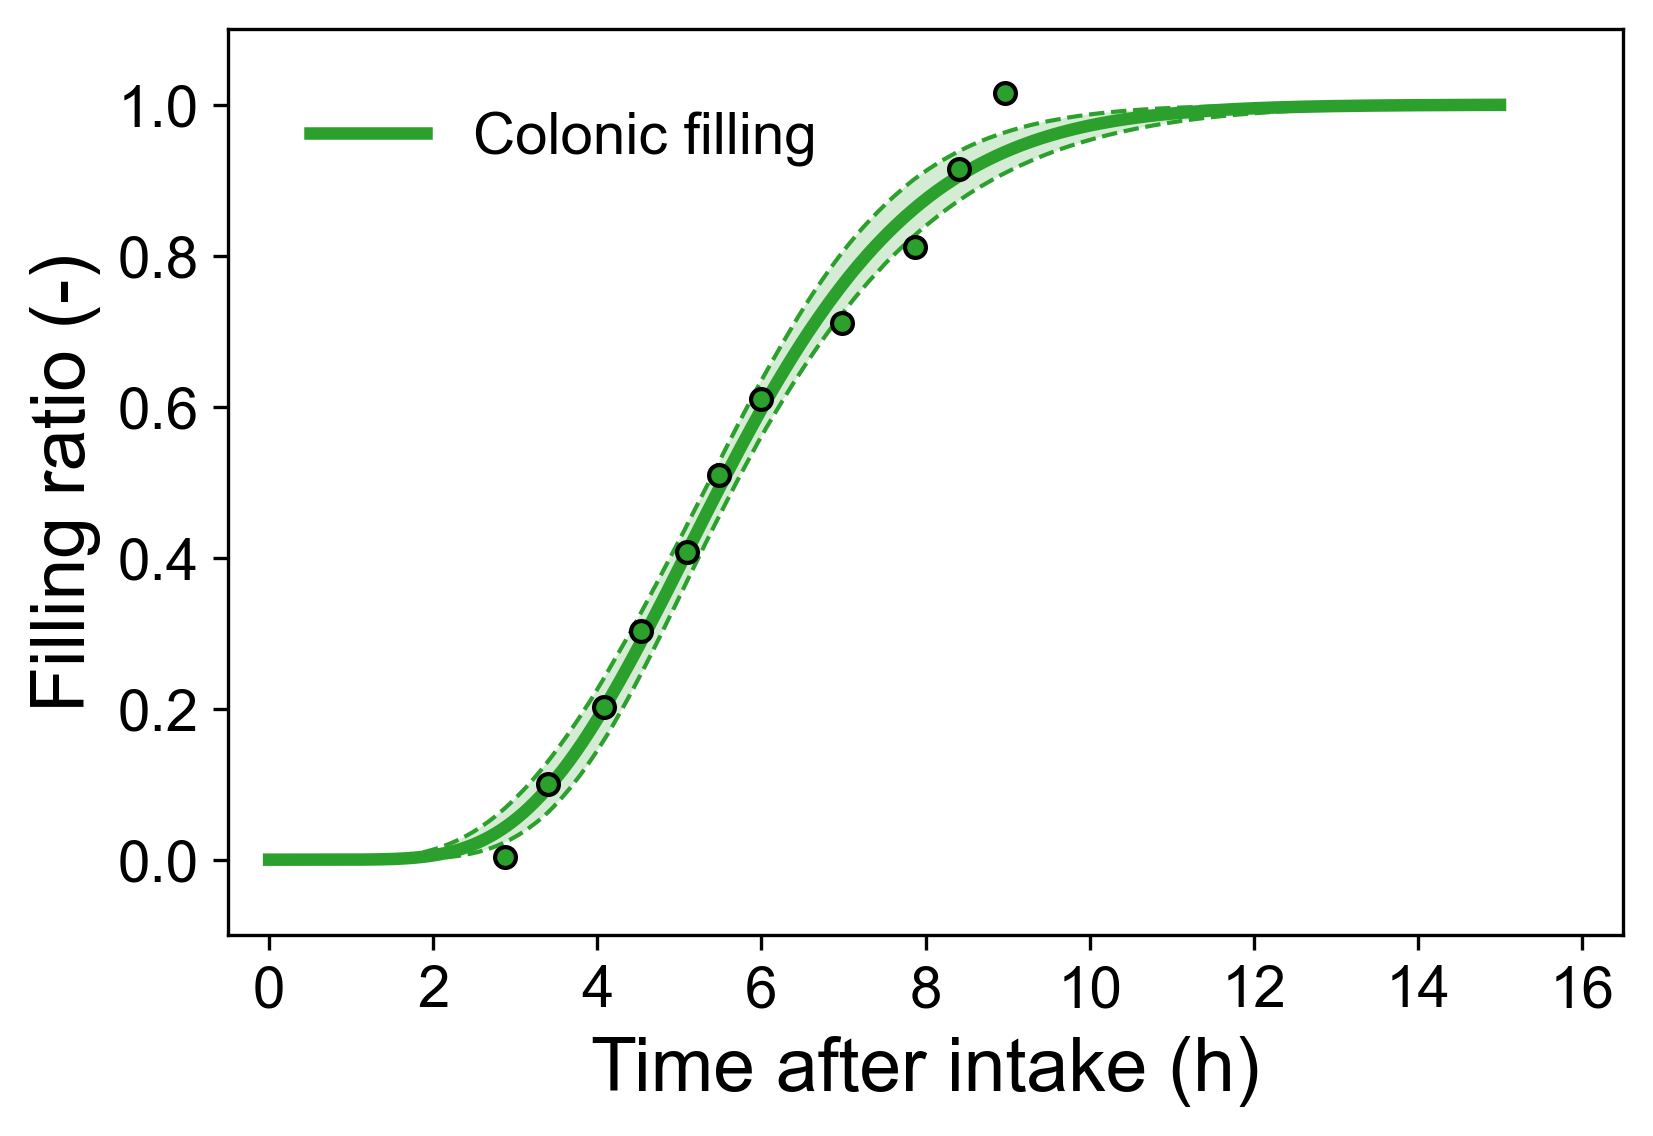

In [9]:
plt.figure(dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
Palette=sns.color_palette(n_colors=3)
x =  np.zeros((15*60+1, 1), dtype=float)
x[:,0] = np.linspace(0, 15, 15*60+1)
for i in tqdm(range(len(samples_Colonic_filling["lp__"])),desc='Progress', leave=False):
    alpha = samples_Colonic_filling["alpha"][i]
    beta = samples_Colonic_filling["beta"][i]
    sigma = samples_Colonic_filling["sigma"][i]
    Colonic_filling = gamma.cdf(x*60, alpha, loc=0, scale=1./beta)
    if i == 0:
        Colonic_filling_list = Colonic_filling
    else:
        Colonic_filling_list = np.concatenate([Colonic_filling_list, Colonic_filling], axis = -1) 

Colonic_filling_quantile = np.zeros((15*60+1,7), dtype=float)

for j in tqdm(range(15*60+1),desc='Progress', leave=False):
    Colonic_filling_quantile[j,:] =  np.quantile(Colonic_filling_list[j,:],[0.005, 0.025, 0.20, 0.5, 0.80, 0.975, 0.995])
    
plt.fill_between(x[:,0], Colonic_filling_quantile[:,1], Colonic_filling_quantile[:,5], facecolor=Palette[2], alpha=0.2)
plt.plot(x[:,0], Colonic_filling_quantile[:,1], lw=1, color=Palette[2], linestyle='--')
plt.plot(x[:,0], Colonic_filling_quantile[:,5], lw=1, color=Palette[2], linestyle='--')
plt.plot(x[:,0], Colonic_filling_quantile[:,3], lw=3, color=Palette[2], label="Colonic filling")

plt.plot(datum["Time"]/60, datum["Filling"], color = Palette[2], markeredgecolor="black", marker = "o",  linestyle = "none", markersize = 5)

plt.ylabel("Filling ratio (-)",size=18,fontname="Arial")
plt.xlabel("Time after intake (h)",size=18,fontname="Arial")
plt.legend(loc='upper left', borderaxespad=1, fontsize=14, frameon = False)
plt.xlim(-0.5, 16.5)
plt.ylim(-0.1, 1.1)
plt.show()

Max retention time17.887143863348292


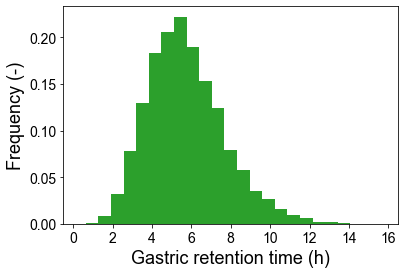

In [10]:
plt.rcParams["font.family"] = "Arial"
plt.xticks(size=14)
plt.yticks(size=14)
samples_Colonic_filling = fit_nuts_Colonic_filling.extract(permuted=True)
Num_mcmc_Retention_time = len(samples_Colonic_filling["lp__"])
dist_sim_retention_time_hour=[]
for i in tqdm(range(10**4),desc='Progress', leave=False):
    random_choice_number = random.choice(range(Num_mcmc_Retention_time))
    sim_retention_time_hour = np.random.gamma(
        samples_Colonic_filling["alpha"][random_choice_number],
        1/samples_Colonic_filling["beta"][random_choice_number])/60
    dist_sim_retention_time_hour.append(sim_retention_time_hour)

dist_sim_retention_time_hour.sort()
plt.hist(dist_sim_retention_time_hour,bins=25,density=True,range=(0,16),color=Palette[2])
plt.ylabel("Frequency (-)",size=18,fontname="Arial")
plt.xlabel("Gastric retention time (h)",size=18,fontname="Arial")
np.median(dist_sim_retention_time_hour)
plt.xlim(-0.5, 16.5)

print("Max retention time"+str(np.max(dist_sim_retention_time_hour)))

with open('dist_sim_retention_time_colon_hour.pkl', 'wb') as f:

    pickle.dump(dist_sim_retention_time_hour, f)

In [11]:
np.mean(dist_sim_retention_time_hour)

5.740453281334848

In [12]:
np.std(dist_sim_retention_time_hour)

1.952178296565324